In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from mapie.regression import MapieQuantileRegressor

SEED = 42

2024-11-20 10:53:28.135812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 10:53:28.145659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732096408.157216  100254 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732096408.160914  100254 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 10:53:28.172648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# **Prepare data**

Load, preprocess and split data into train, test and calibration sets:

In [2]:
data = fetch_california_housing()
X, y = data.data, data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test_cal, y_train, y_test_cal = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_test, X_cal, y_test, y_cal = train_test_split(X_test_cal, y_test_cal, test_size=0.5, random_state=SEED)

print('Train: ', len(X_train))
print('Test: ', len(X_test))
print('Calibration: ', len(X_cal))

Train:  14448
Test:  3096
Calibration:  3096


# **Train and save models**

Create, train and save Keras models:

* `model_up` with tau = (1-alpha)/2
* `model_low` with tau = alpha/2
* `model` with tau = 0.5

In [3]:
def pinball_loss(y_true, y_pred, tau=0.5):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(tau * error, (tau - 1) * error))

def train_and_save_model(loss_fn, file_name):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss=loss_fn)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=.2, verbose=0)
    model.save(file_name)
    return model

# def train_and_save_model_2(loss_fn, file_name):
#     model = Sequential([
#         Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss=loss_fn)
#     model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=.2, verbose=0)
#     model.save(file_name)
#     return model

# def train_and_save_model_3(loss_fn, file_name):
#     model = Sequential([
#         Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),
#         Dense(32, activation='sigmoid'),
#         Dense(16, activation='relu'),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss=loss_fn)
#     model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=.2, verbose=0)
#     model.save(file_name)
#     return model

alpha = .1

# model_list = [
#     train_and_save_model(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(1-alpha)/2), 'model_up.keras'),
#     train_and_save_model_2(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(alpha/2)), 'model_low.keras'),  
#     train_and_save_model_3('mse', 'model.keras')
# ]

model_list = [
    train_and_save_model(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(1-alpha)/2), 'model_up.keras'),
    train_and_save_model(lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(alpha/2)), 'model_low.keras'),  
    train_and_save_model('mse', 'model.keras')
]

/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732096409.548150  100254 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1732096410.466208  100542 service.cc:148] XLA service 0x708c9c007020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732096410.466224  100542 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-20 10:53:30.478405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mli

# **MAPIE**

Load and wrap for `sklearn` compatibility (the wrapper assumes that the model is already trained):

In [4]:
class TrainedKerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def __sklearn_is_fitted__(self):
        return True


# loaded_model = load_model('model.keras')
# model = TrainedKerasRegressorWrapper(loaded_model)

model_files = ['model_low.keras', 'model_up.keras', 'model.keras']
wrapped_models = []

for file in model_files:
    loaded_model = load_model(file, compile=False)
    wrapped_model = TrainedKerasRegressorWrapper(loaded_model)
    wrapped_models.append(wrapped_model)

MAPIE quantile regression.

The list of estimators consist of:

* [0]: Estimator with quantile value of alpha/2
* [1]: Estimator with quantile value of 1 - alpha/2
* [2]: Estimator with quantile value of 0.5
```

In [5]:
mapie_regressor = MapieQuantileRegressor(
    estimator=wrapped_models, cv='prefit')

mapie_regressor.fit(X_cal, y_cal)

predictions, intervals = mapie_regressor.predict(X_test)

lower_intervals = intervals[:, 0]
upper_intervals = intervals[:, 1]

results = pd.DataFrame({
    'Prediction': predictions.flatten(),
    'Lower Interval': lower_intervals.flatten(),
    'Upper Interval': upper_intervals.flatten(),
    'Amplitude': upper_intervals.flatten() - lower_intervals.flatten(),
    'Actual Value': y_test
})

results.head()

 1/97 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step

/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/home/antonio/code/uncertainty-pinns/.venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


,Prediction,Lower Interval,Upper Interval,Amplitude,Actual Value
0,1.521790,0.146996,2.156779,2.009783,1.225
1,3.421173,2.300114,4.056391,1.756276,3.204
2,4.472052,2.875749,4.941036,2.065287,4.507
3,2.843897,1.374000,3.279121,1.905121,2.343
4,1.527215,0.453412,2.087752,1.634341,1.019


# **Plot intervals**

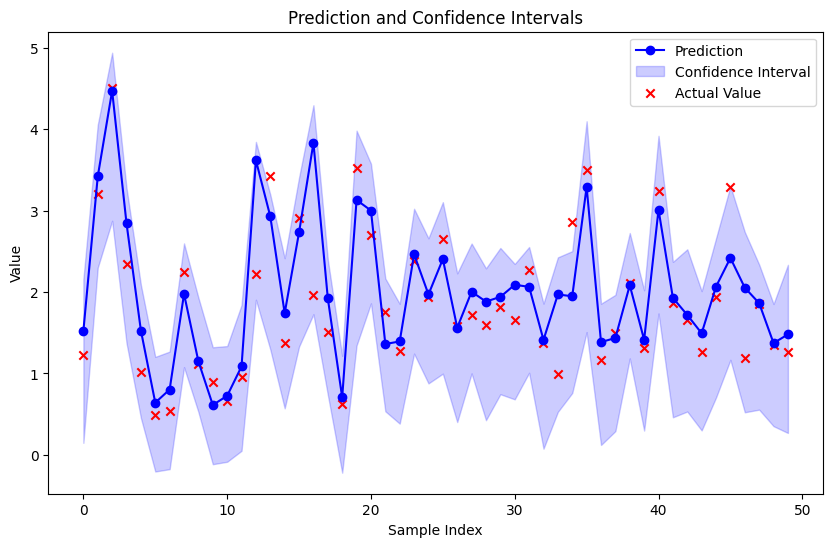

In [6]:
indices = np.arange(len(X_test))[:50]

plt.figure(figsize=(10, 6))

plt.plot(indices, results['Prediction'][:50], label='Prediction', color='blue', marker='o')
plt.fill_between(indices, results['Lower Interval'][:50], results['Upper Interval'][:50],
                 color='blue', alpha=0.2, label='Confidence Interval')
plt.scatter(indices, results['Actual Value'][:50], color='red', label='Actual Value', marker='x')

plt.title('Prediction and Confidence Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()
